# TeslaMax Optimization

Teslamax model:

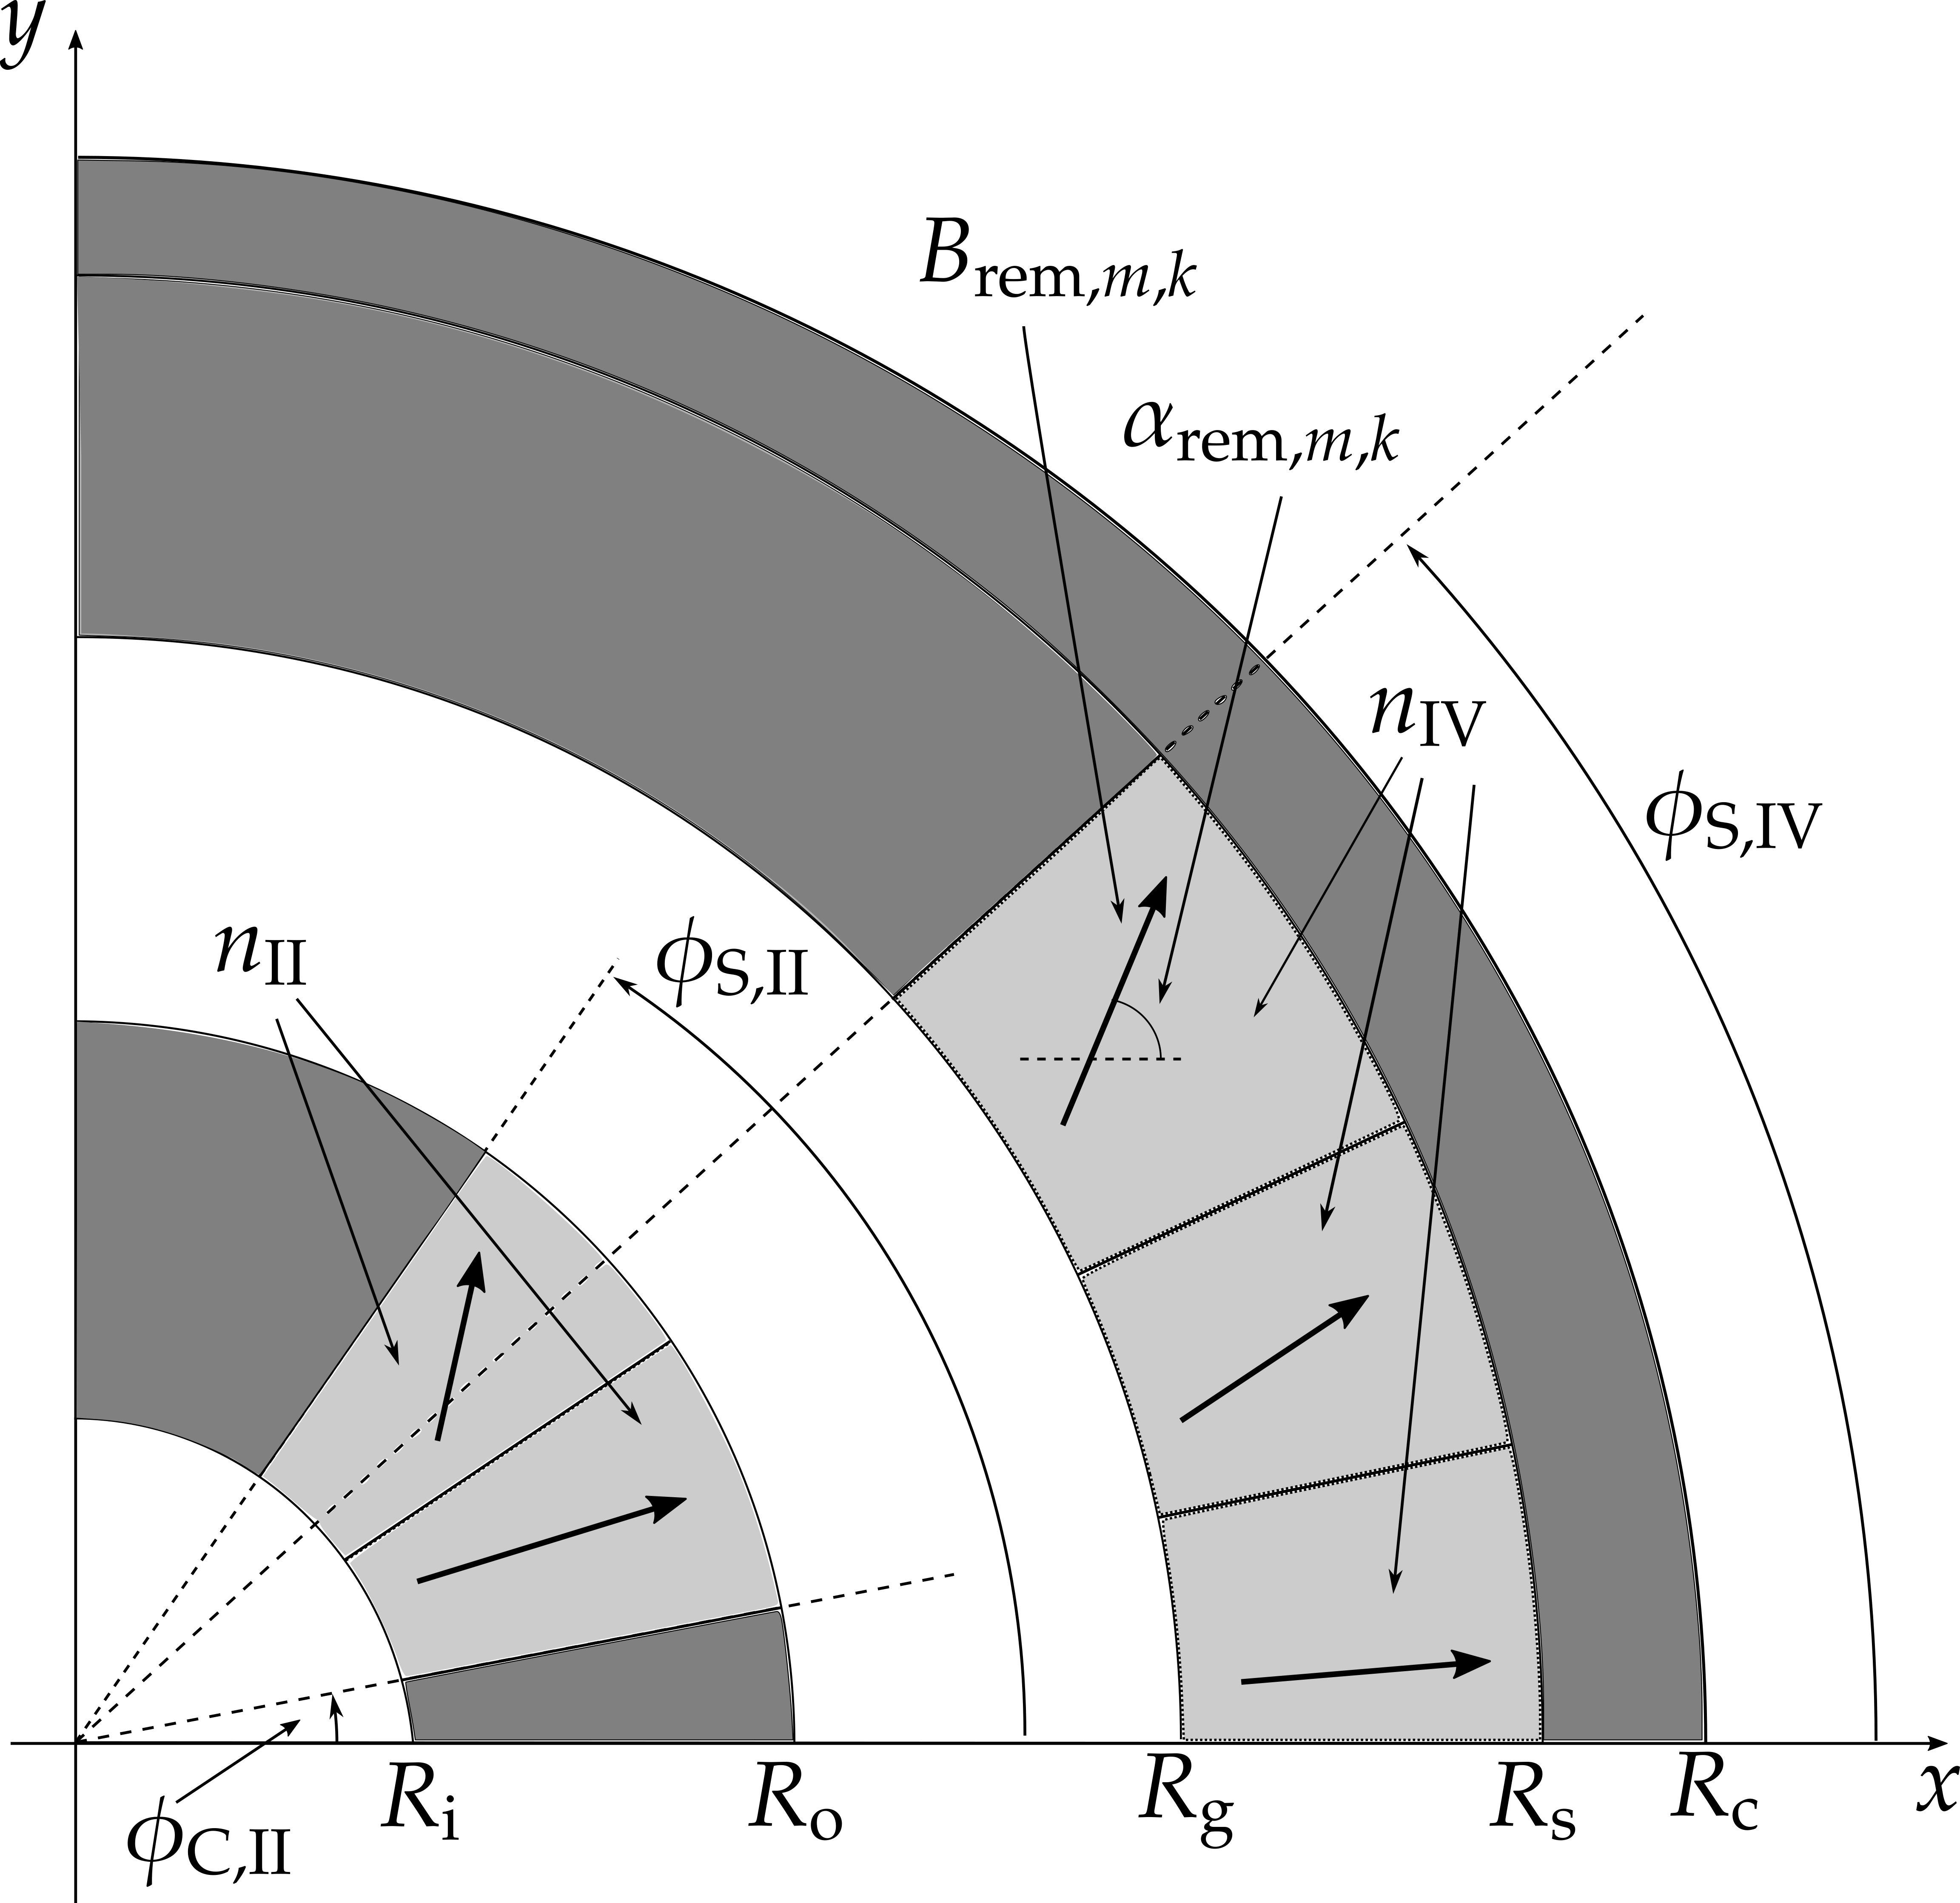

In [1]:
from IPython.display import Image, display, HTML
Image("figures/teslamax.png",width=500)

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [2]:
from pathlib import Path
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
from scipy.optimize import minimize, differential_evolution, basinhopping
from scipy.interpolate import interp1d
from pandas import Series, DataFrame
import pandas as pd
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

In [3]:
plt.set_cmap(cmap="Greys")

<Figure size 432x288 with 0 Axes>

In [4]:
import nemplot
from nemplot import nemplot_parameters

In [5]:
nemplot.set_dpi(800)
nemplot.set_figsize_cm(12)
nemplot.set_fontsize(14)
nemplot.set_latex_font("Palatino")
nemplot.set_plot_extension('.pdf')

THESIS_DIR = Path.home() / "latex-writing" / "phd-thesis-fabiofortkamp"

nemplot.set_main_path(THESIS_DIR)
nemplot.set_figures_dir('fig')

In [6]:
B_HIGH_LIMIT = 1.2

TESLAMAX_PATH = Path.home() / "code" / "TeslaMax"

PLAYGROUND_DIR = "teslamax-play"

RAMP_RESULTS_DIR_FMT = "ramp_Bh_%d_FM_%d"

TESLAMAX_MPH_DIR = TESLAMAX_PATH / "java"

TESLAMAX_FILENAME = "TeslaMax_Model"
TESLAMAX_FILE_EXT = "mph"

TESLAMAX_FILE_STR = str(TESLAMAX_MPH_DIR / (TESLAMAX_FILENAME + "." + TESLAMAX_FILE_EXT))


TESLAMAX_PLAYGROUND = TESLAMAX_PATH / PLAYGROUND_DIR

In [24]:
DICT_LINES = 19
K_CRITIC = 0.002
K_STEP = 0.002

B_LABEL = r'$B\ped{max}\,[\si{\tesla}]$'
Q_LABEL = r'$\qc\,[\si{\watt}]$'
COP_LABEL = r'$\cop$'
PHI_LABEL = r'$\Phi$'
H_REG_LABEL = r'$H\ped{r}\,[\si{\milli\meter}]$'
H_GAP_LABEL = r'$h\ped{gap}\,[\si{\milli\meter}]$'
F_B_LABEL = r'$F\ped{B}\,[\si{\percent}]$'
F_M_LABEL = r'$F\ped{M}\,[\si{\percent}]$'
H_MAX_LABEL = r'$\mu_0 H\ped{max}\,[\si{\tesla}]$'

In [8]:
os.getcwd()

'/Users/fabiofortkamp/code/TeslaMax'

## Superposition

In [17]:
param_dict_superpos = {"R_i": 0.015,
              "R_o": 0.070,
              "h_gap": 0.020,
              "R_s": 0.140,
              "h_fc": 0.005,
              "R_e": 0.3,
              "n_IV": 1,
              "phi_S_IV": 45,
              "n_II": 1,
              "phi_C_II": 0,
              "phi_S_II": 45,
              "B_rem_II_1": 1.4,
              "mu_r_II": 1.05,
              "B_rem_IV_1": 1.4,
              "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,}


alpha_rem_vector_superpos = np.array([15, 15])
tmpd_superpos = TeslaMaxPreDesign(param_dict_superpos)
tmm_superpos = TeslaMaxModel(tmpd_superpos,
                    alpha_rem_vector_superpos,
                    path=TESLAMAX_PLAYGROUND)

tmm_superpos.run()

R_o = param_dict_superpos["R_o"]
R_g = R_o + param_dict_superpos["h_gap"]

points_gap = teslamax.generate_sector_mesh_points(R_o,R_g,0,np.pi/2)

B_total_superpos = tmm_superpos.calculate_B_III_from_position(points_gap)

B_inner_superpos = tmpd_superpos.calculate_B_III_from_single_block(point=points_gap,
                                                 angle=alpha_rem_vector_superpos[0],
                                                 magnet='II',
                                                 magnitude=param_dict_superpos["B_rem_II_1"],
                                                 segment=1)

B_outer_superpos = tmpd_superpos.calculate_B_III_from_single_block(point=points_gap,
                                                 angle=alpha_rem_vector_superpos[1],
                                                 magnet='IV',
                                                 magnitude=param_dict_superpos["B_rem_IV_1"],
                                                 segment=1)

dev_B_superposition = (B_total_superpos - (B_outer_superpos + B_inner_superpos))/B_total_superpos * 100
dev_B_x, dev_B_y = dev_B_superposition.T

x_vector, y_vector = 1e3*points_gap.T

dev_B_superposition_magnitude = teslamax.calculate_magnitude(np.array([x_vector,
                                                            y_vector,
                                                            dev_B_x,
                                                            dev_B_y]).T).T[2]




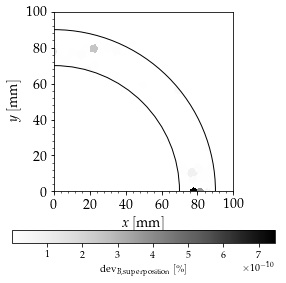

In [27]:
%matplotlib inline

plt.set_cmap(cmap="Greys")

fig, axes = nemplot.create_plot(xlabel=r'$x\,[\si{\milli\meter}]$',
                                 ylabel=r'$y\,[\si{\milli\meter}]$')
axes.set_aspect('equal')
axes.set_xlim(0,1e3*R_g)
axes.set_ylim(0,1e3*R_g)
nemplot.refine_xticks(axes,5)
nemplot.refine_yticks(axes,5)


#pcolormesh deals with 2D arrays, so we reshape our vectors
number_of_points_per_axes = int(math.sqrt(len(x_vector)))
mesh_shape = ( number_of_points_per_axes, number_of_points_per_axes)



B_mesh = axes.pcolormesh(x_vector.reshape(mesh_shape),
                        y_vector.reshape(mesh_shape),
                           dev_B_superposition_magnitude.reshape(mesh_shape))

#annotate the plot
B_colorbar = fig.colorbar(B_mesh,orientation='horizontal')
B_colorbar.set_label(r'$\mathrm{dev}_{B,\mathrm{superposition}}\ [\si{\percent}]$')

params = tmpd_superpos.geometry.geometric_parameters

R_o = params['R_o']
R_i = params['R_i']
R_s = params['R_s']
R_g = params.get('R_g', params['R_o'] + params['h_gap'])

gap_outer = plt.Circle((0, 0), 1e3 * R_o, color='k', fill=False)
gap_inner = plt.Circle((0, 0), 1e3 * R_g, color='k', fill=False)
axes.add_artist(gap_outer)
axes.add_artist(gap_inner)

nemplot.save_figure(fig,'dev_B_superposition')

## Compact magnet, fixed parameters

These are the parameters that are being used to study more compact systems:

In [9]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "H[m]": 19e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_s": 100e-3,
                "h_gap": FIXED_PARAMETERS_AMR["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_casing[m]"] + 
                                                                    FIXED_PARAMETERS_AMR["t_air[m]"]),
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "phi_S_IV": 45,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

B_HIGH = 1.0
B_LOW = 0.0
F_M = 0.35

n_II = FIXED_PARAMETERS_MAGNET["n_II"]
n_IV = FIXED_PARAMETERS_MAGNET["n_IV"]
n = n_II + n_IV

B_rem = 1.4
B_REM = B_rem

# expand parameters to include remanence magnitudes for each segment
FIXED_PARAMETERS_MAGNET = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      FIXED_PARAMETERS_MAGNET, 
                                                                      "B_rem")

## Optimization using Scipy

In [10]:
def optimize_ramp(B_high,field_fraction,params):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside "teslamax-play".
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    target_args = (B_high,B_LOW,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / sdir )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    return (tmm_g,cost_function)
    

In [10]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [12]:
def plot_optimized_ramp(B_high,field_fraction):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations
    and a ramp profile between 0 and 'B_high', with 'field_fraction'. The TeslaMax
    results are read from the appropriate files inside PLAYGROUND_DIR.
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    """
 

    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = TESLAMAX_PATH / PLAYGROUND_DIR / sdir
    
    profile_file = teslamax_playground / teslamax.MAGNETIC_PROFILE_FILENAME
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    phi_vector_g, B_vector_g = teslamax.read_comsol_profile_data(str(profile_file))
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_g,B_vector_g,linewidth=0.7*lw,color='k')
    profile_axes_g.set_xlim(0,np.max(phi_vector_g))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    #profile_axes_g.set_yticks(np.arange(0,B_HIGH_LIMIT+0.2,0.2),minor=True)
    
    B_low = 0.0
    B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_LOW,field_fraction)
    profile_axes_g.plot(phi_vector_g,B_inst_vector,'--',linewidth=lw,color='gray')

    nemplot.save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))

### Influence of B_max, meaning of K

We test three different values of the high field to study the scale of K:

In [13]:
%%time

os.chdir(TESLAMAX_PATH)

B_high = 0.9

tmm_g_2, K_2 = optimize_ramp(B_high,F_M,FIXED_PARAMETERS_MAGNET)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.00124960615542
Wall time: 7min 55s


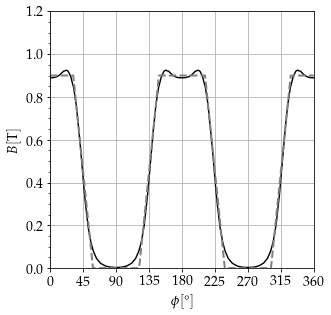

In [14]:
%matplotlib inline

plot_optimized_ramp(B_high,F_M)

In [15]:
%%time

os.chdir(TESLAMAX_PATH)

B_high = 0.95

tmm_g_2, K_2 = optimize_ramp(B_high,F_M,FIXED_PARAMETERS_MAGNET)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.00130564837851
Wall time: 9min 45s


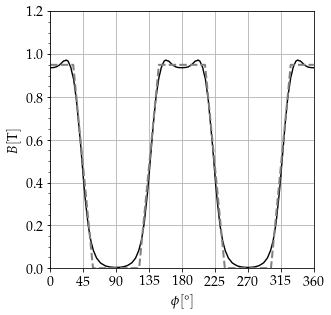

In [16]:
%matplotlib inline

plot_optimized_ramp(B_high,F_M)

In [18]:
%%time

os.chdir(TESLAMAX_PATH)

B_high = 1.00

tmm_g_2, K_2 = optimize_ramp(B_high,F_M,FIXED_PARAMETERS_MAGNET)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.00175571862067
Wall time: 8min 23s


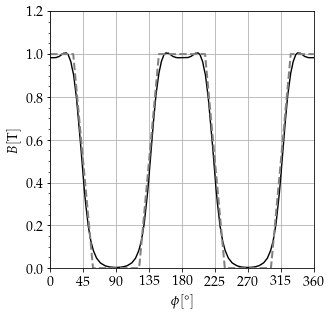

In [19]:
%matplotlib inline

plot_optimized_ramp(B_high,F_M)

In [20]:
%%time

os.chdir(TESLAMAX_PATH)

B_high = 1.05

tmm_g_2, K_2 = optimize_ramp(B_high,F_M,FIXED_PARAMETERS_MAGNET)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.00354770357795
Wall time: 7min 43s


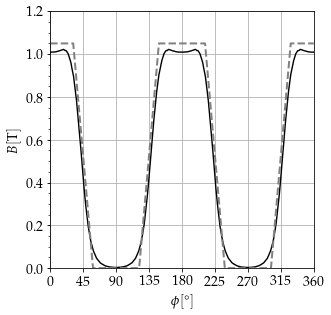

In [21]:
%matplotlib inline

plot_optimized_ramp(B_high,F_M)

So it seems that, based on visual inspection, the optimization procedure is acceptable if $K \le 0.002$.

## Comparison of dividing angles

In [16]:
def optimize_ramp_with_timestamp(B_high,field_fraction,params,filename=None):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside PLAYGROUND_DIR.
    The COMSOL model file is saved as 'filename' (with '.mph' extension) in TESLAMAX_MPH_DIR, 
    if provided.
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile

    
    target_args = (B_high,B_LOW,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    tstamp = datetime.now().strftime("%Y%m%d%H%M%S")
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / tstamp  )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    if filename:
        shutil.copy(src=TESLAMAX_FILE_STR,
                    dst=str(TESLAMAX_MPH_DIR / (filename + "." + TESLAMAX_FILE_EXT)))
    
    return (tmm_g,cost_function)
    

In [23]:
def run_optimized_ramp_comparison_angles(B_high,field_fraction,params,phi_S_values):
    """
    Run a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation  and dividing angles in 'phi_S_values'. 
    
    Common parameters for the case with the magnet are read from 'params', 

    Save the corresponding COMSOL models.
    """
    
    p = params.copy()

    results_list = []
    
    for i, phi_S in enumerate(phi_S_values):
        
        p["phi_S_IV"] = phi_S
        p["phi_S_II"] = phi_S
            
        tm_file = TESLAMAX_FILENAME + "_phi_S_%d" %(phi_S,)
        tmm, K = optimize_ramp_with_timestamp(B_high,field_fraction,p,tm_file)
        
        results_list.append((tmm,K))
    
    return results_list

In [30]:
def plot_optimized_ramp_comparison_angles(B_high,field_fraction,phi_S_values,results_list):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation and dividing angles in 'phi_S_values'. 
    
    Assumes the results are saved such that results_list[i] corresponds to phi_C_values[i].
    
    Save the figure with the appropriate naming.
    """
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    lw = 2.0
    
    linestyles = ['-.','-', ':','--']
    for i, phi_S in enumerate(phi_S_values):
        
        (tmm, K) = results_list[i]

        phi_vector, B_vector = tmm.get_profile_data()
        
        label_str = r'$\phi\ped{S,IV} = \SI{' + "%d" %(phi_S,) + r'}{\degree}$'
        profile_axes_g.plot(phi_vector,B_vector,
                            color="gray",
                            linestyle=linestyles[i],
                            linewidth=lw,label=label_str)
    
    profile_axes_g.set_xlim(0,np.max(phi_vector))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)

    B_target_vector = teslamax.calculate_ramp_profile(phi_vector,B_high,B_LOW,field_fraction)
    profile_axes_g.plot(phi_vector,B_target_vector,
                        color='k',
                        linestyle='--',
                        linewidth=lw,label="Target")
    
    profile_axes_g.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

    nemplot.save_figure(profile_fig_g,"profile_comparison_phi_S")


### Testing angles

In [28]:
os.chdir(TESLAMAX_PATH)

phi_S_values = [35,45,55]

results_list_phi_S = run_optimized_ramp_comparison_angles(B_HIGH,
                                                     F_M,
                                                     FIXED_PARAMETERS_MAGNET,
                                                     phi_S_values)


    

***
For angle 35 °:
Value of K: 0.033519

Parameters:
{'R_i': 0.015, 'R_o': 0.04, 'h_fc': 0.005, 'R_s': 0.1, 'h_gap': 0.022, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_IV': 35, 'phi_S_II': 35, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'B_rem_II_1': 1.3999999999999999, 'B_rem_II_2': 1.3999999999999999, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'R_g': 0.062, 'alpha_rem_II_1': 172.36353659990019, 'alpha_rem_II_2': 148.87859145668773, 'alpha_rem_IV_1': 7.9708131243664964, 'alpha_rem_IV_2': 26.82927097608513, 'alpha_rem_IV_3': 54.540366879893732, 'alpha_rem_IV_4': 95.303482867775244}
***
For angle 45 °:
Value of K: 0.001755

Parameters:
{'R_i': 0.015, 'R_o': 0.04, 'h_fc': 0.005, 'R_s': 0.1, 'h_gap': 0.022, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_IV': 45, 'phi_S_II': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 500

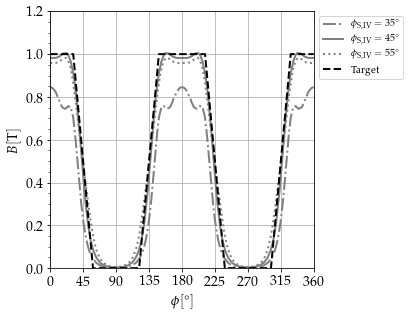

In [32]:
%matplotlib inline

plot_optimized_ramp_comparison_angles(B_HIGH,
                                      F_M,
                                      phi_S_values,
                                      results_list_phi_S)

for i in range(0,len(phi_S_values)):
    
    (tmm, K) = results_list_phi_S[i]
    
    print("***")
    print("For angle %d °:" %(phi_S_values[i]))
    print("Value of K: %.6f" %(K))
    print()
    print("Parameters:")
    print(tmm.params)

## Analysis of $\phi_{\mathrm{C,II}}$

In [17]:
def run_optimized_ramp_comparison_phi_C(B_high,field_fraction,params,phi_C_values):
    """
    Run a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation internal iron wedge angles in 'phi_C_values'. 
    
    Common parameters for the case with the magnet are read from 'params', 
    
    
    Save the corresponding COMSOL models.
    """
    
    p = params.copy()
    
    results_list = []
    for i, phi_C in enumerate(phi_C_values):
        
        p["phi_C_II"] = phi_C
            
        tm_file = TESLAMAX_FILENAME + "_phi_C_%d" %(phi_C,)
        tmm_magnet, K_magnet = optimize_ramp_with_timestamp(B_high,field_fraction,p,tm_file)
        
        results_list.append((tmm_magnet,K_magnet))
    
    return results_list

In [18]:
def plot_optimized_ramp_comparison_phi_C(B_high,field_fraction,phi_C_values,results_list):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation internal iron wedge angles in 'phi_C_values'. 
    
    Assumes the results are saved such that results_list[i] corresponds to phi_C_values[i]
    """
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    lw = 2.0
   
    linestyles = ['-', ':', '-.','--']
    for i, phi_C in enumerate(phi_C_values):
        
        (tmm_magnet, K_magnet) = results_list[i]

        phi_vector, B_vector = tmm_magnet.get_profile_data()
        
        label_str = r'$\phi\ped{C,II} = \SI{' + "%d" %(phi_C,) + r'}{\degree}$'
        profile_axes_g.plot(phi_vector,B_vector,
                            color='gray',
                            linestyle=linestyles[i],
                            linewidth=lw,label=label_str)
    
    profile_axes_g.set_xlim(0,np.max(phi_vector))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
    
    B_target_vector = teslamax.calculate_ramp_profile(phi_vector,B_high,B_LOW,field_fraction)
    profile_axes_g.plot(phi_vector,B_target_vector,'--',color='k',linewidth=lw,label="Target")
    
    profile_axes_g.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

    nemplot.save_figure(profile_fig_g,"profile_comparison_phi_C")

In [19]:
os.chdir(TESLAMAX_PATH)

phi_C_values = [5,15]

results_list_phi_C = run_optimized_ramp_comparison_phi_C(B_HIGH,
                                                     F_M,
                                                     FIXED_PARAMETERS_MAGNET,
                                                     phi_C_values)

***
For phi_C 5 °:
Value of K: 0.001960

Parameters:
{'R_i': 0.015, 'R_o': 0.04, 'h_fc': 0.005, 'R_s': 0.1, 'h_gap': 0.022, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 5, 'phi_S_IV': 45, 'phi_S_II': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'B_rem_II_1': 1.3999999999999999, 'B_rem_II_2': 1.3999999999999999, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'R_g': 0.062, 'alpha_rem_II_1': 0.0, 'alpha_rem_II_2': 6.4590248521035845, 'alpha_rem_IV_1': 7.1171108253403759, 'alpha_rem_IV_2': 13.296441747990324, 'alpha_rem_IV_3': 34.834894138343074, 'alpha_rem_IV_4': 92.223916849900178}
***
For phi_C 15 °:
Value of K: 0.001739

Parameters:
{'R_i': 0.015, 'R_o': 0.04, 'h_fc': 0.005, 'R_s': 0.1, 'h_gap': 0.022, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_IV': 45, 'phi_S_II': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'B_rem_II_1

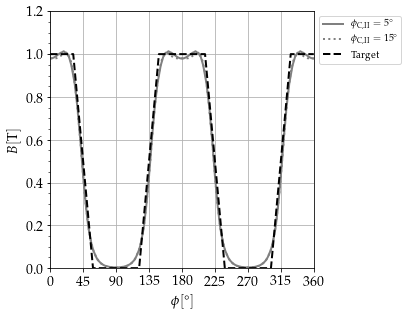

In [20]:
%matplotlib inline

plot_optimized_ramp_comparison_phi_C(B_HIGH,
                                     F_M,
                                     phi_C_values,
                                     results_list_phi_C)

for i in range(0,len(phi_C_values)):
    
    (tmm_magnet, K_magnet) = results_list_phi_C[i]
    
    print("***")
    print("For phi_C %d °:" %(phi_C_values[i]))
    print("Value of K: %.6f" %(K_magnet))
    print()
    print("Parameters:")
    print(tmm_magnet.params)
    

## Comparison with and without magnet

In [21]:
def run_optimized_ramp_comparison_internal_magnet(B_high,field_fraction,params,H_reg,R_s,R_o):
    """
    Run a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation with and without the internal magnet. 
    
    Common parameters for the case with the magnet are read from 'params', 
    and regenerator height and external radii for both magnets are provided separately 
    for comparing different cases. This function calculates the parameters 
    for the case without magnet.
    

    Save the corresponding COMSOL models.
    """

    params_no_magnet = params.copy()
    params_no_magnet["phi_C_II"] = 0
    params_no_magnet["phi_S_II"] = 0
    params_no_magnet["n_II"] = 0
    
    for p in [params,params_no_magnet]:
        
        p["H[m]"] = H_reg
        p["R_s"] = R_s
        p["R_o"] = R_o
        p["h_gap"] = p["H[m]"] + 2*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
        
        n_II = p["n_II"]
        n_IV = p["n_IV"]
            
        n = n_II + n_IV
        
        # expand parameters to include remanence magnitudes for each segment
        p.update(teslamax.expand_parameters_from_remanence_array(B_REM*np.ones(n), 
                                                        p, 
                                                        "B_rem"))
    
    params_str = "_B_%d_H_%d_Rs_%d_Ro_%d" %(B_high*1000,H_reg*1e3,R_s*1e3,R_o*1e3)
    
    tm_file_magnet = TESLAMAX_FILENAME + "_magnet" + params_str
    tmm_magnet, K_magnet = optimize_ramp_with_timestamp(B_high,field_fraction,params,tm_file_magnet)
    
    tm_file_no_magnet = TESLAMAX_FILENAME + "_no_magnet" + params_str
    tmm_no_magnet, K_no_magnet = optimize_ramp_with_timestamp(B_high,field_fraction,params_no_magnet,tm_file_no_magnet)
    
    return (tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet)


In [31]:
def plot_optimized_ramp_comparison_internal_magnet(B_high,field_fraction,params,H_reg,R_s,R_o,tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations,
    and a ramp profile between 0 and 'B_high', with 'field_fraction', 
    for a situation with and without the internal magnet. 
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    Save the corresponding COMSOL models.
    """

    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    params_str = "_B_%d_H_%d_Rs_%d_Ro_%d" %(B_high*1000,H_reg*1e3,R_s*1e3,R_o*1e3)
    
    phi_vector_magnet, B_vector_magnet = tmm_magnet.get_profile_data()
    phi_vector_no_magnet, B_vector_no_magnet = tmm_no_magnet.get_profile_data()
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_magnet,B_vector_magnet,'k:',linewidth=lw,label="With internal magnet")
    profile_axes_g.plot(phi_vector_no_magnet,B_vector_no_magnet,'k-',linewidth=lw,label='No internal magnet')
    
    profile_axes_g.set_xlim(0,np.max(phi_vector_magnet))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_magnet),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    
    B_target_vector = teslamax.calculate_ramp_profile(phi_vector_magnet,B_high,B_LOW,field_fraction)
    profile_axes_g.plot(phi_vector_magnet,B_target_vector,'k--',linewidth=lw,label="Target")
    
    profile_axes_g.legend(loc='upper left',bbox_to_anchor=(1.0,1.0))

    nemplot.save_figure(profile_fig_g,"profile_comparison_magnet" + params_str)



### Testing 3 points for R_o = 40 mm

This value for the external radius of the internal magnet has been used as a typical estimative, to fit 8 regenerators of 30 mm of width into a gap of 20 mm and use about 85% of the gap (leaving space for the walls and other structural elements, such as screws).

We select three operating points from that curve and test the profiles, with and without the internal magnet

In [26]:
R_s = 120e-3
R_o = 40e-3

In [29]:
%matplotlib inline

os.chdir(TESLAMAX_PATH)

B_HIGH_LIMIT = 1.3

B_max = 1.20
H_reg = 19e-3

tmm_magnet, K_magnet, tmm_no_magnet, K_no_magnet = run_optimized_ramp_comparison_internal_magnet(B_max,
                                                                                                  F_M,
                                                                                                  FIXED_PARAMETERS_MAGNET,
                                                                                                  H_reg,
                                                                                                  R_s,
                                                                                                  R_o)

print("Value of K with magnet: %.6f" %(K_magnet))
print("Parameters:")
print(tmm_magnet.params)
print("Value of K without magnet: %.6f" %(K_no_magnet))
print("Parameters:")
print(tmm_no_magnet.params)

Value of K with magnet: 0.001953
Parameters:
{'R_i': 0.015, 'R_o': 0.04, 'h_fc': 0.005, 'R_s': 0.12, 'h_gap': 0.022, 'R_e': 0.3, 'n_II': 2, 'n_IV': 4, 'phi_C_II': 15, 'phi_S_IV': 45, 'phi_S_II': 45, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'B_rem_II_1': 1.3999999999999999, 'B_rem_II_2': 1.3999999999999999, 'B_rem_IV_1': 1.3999999999999999, 'B_rem_IV_2': 1.3999999999999999, 'B_rem_IV_3': 1.3999999999999999, 'B_rem_IV_4': 1.3999999999999999, 'H[m]': 0.019, 'R_g': 0.062, 'alpha_rem_II_1': 23.272927475666432, 'alpha_rem_II_2': 8.1846716659818934, 'alpha_rem_IV_1': 6.0113294643018085, 'alpha_rem_IV_2': 18.014430571529306, 'alpha_rem_IV_3': 46.796017682426424, 'alpha_rem_IV_4': 103.21938012353432}
Value of K without magnet: 0.002871
Parameters:
{'R_i': 0.015, 'R_o': 0.04, 'h_fc': 0.005, 'R_s': 0.12, 'h_gap': 0.022, 'R_e': 0.3, 'n_II': 0, 'n_IV': 4, 'phi_C_II': 0, 'phi_S_IV': 45, 'phi_S_II': 0, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 50

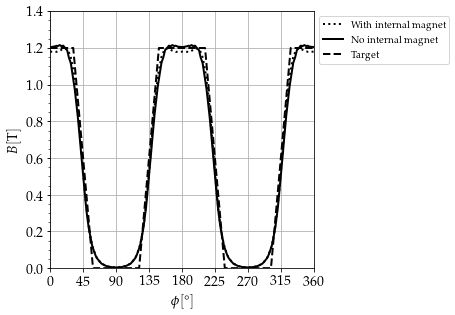

In [32]:
%matplotlib inline

plot_optimized_ramp_comparison_internal_magnet(B_max,
                                              F_M,
                                              FIXED_PARAMETERS_MAGNET,
                                              H_reg,
                                              R_s,
                                              R_o,
                                              tmm_magnet,
                                              K_magnet,
                                              tmm_no_magnet,
                                              K_no_magnet)

## K maps

Now, based on the previous AMR maps, we select an external radius of 100 mm and internal radius of 40 mm, and we vary the air gap height, to see the ability of the TeslaMax model to generate these magnetic profiles.

In [11]:
def filter_table_from_column(table,column,value):
    """
    Return a view into the 'table' DataFrame, selecting only the rows where
    'column' equals 'value'
    """
    
    return table[table[column] == value]

In [12]:
def get_hgap_map_vectors(R_s,phi_S):
    """
    Return (h_gap, B_max, K) as arrays to be plotted with contourf, 
    based on the magnet optimization maps for 'R_s' and 'phi_S'
    """
    
    filename = "map_K_Rs_%d.txt" %(R_s,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
    
    hgap_map_dict_lines = 14
    
    params = eval("".join(flines[0:hgap_map_dict_lines]))
    
    # parse the results file
    column_names = ["phi_S[deg]",
                    "h_gap[mm]",
                    "B_max[T]",
                   "K[]"]
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=hgap_map_dict_lines,names=column_names,header=0)

    map_table = filter_table_from_column(map_table,"phi_S[deg]",phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','K[]')
     
    X=mp.columns.values
    Y=mp.index.values
    K=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,K)

In [13]:
h_gap, B_max, K = get_hgap_map_vectors(100,45)
print(K)

[[0.001041 0.001217 0.001186 0.0011   0.001262 0.001033 0.001195 0.001712
  0.002409 0.004035 0.00632 ]
 [0.001492 0.001216 0.001187 0.001099 0.001271 0.001059 0.001284 0.00196
  0.002758 0.004593 0.007086]
 [0.001519 0.001214 0.001178 0.001088 0.001246 0.001075 0.001423 0.002265
  0.003183 0.005206 0.007905]
 [0.001053 0.001198 0.001156 0.001072 0.00126  0.001221 0.00158  0.002585
  0.003636 0.005868 0.008765]
 [0.001168 0.001178 0.00115  0.00111  0.001239 0.001286 0.001787 0.002944
  0.004159 0.006582 0.009672]
 [0.001039 0.001167 0.001169 0.001072 0.001416 0.001465 0.002052 0.003371
  0.00472  0.007341 0.010618]
 [0.001448 0.001166 0.001141 0.00116  0.001488 0.001628 0.002335 0.003826
  0.005331 0.008145 0.011607]
 [0.001434 0.001147 0.001158 0.001083 0.001507 0.00187  0.00266  0.004335
  0.00599  0.008998 0.012631]
 [0.001443 0.001159 0.00116  0.001238 0.001738 0.002142 0.003019 0.004883
  0.006693 0.009879 0.013692]
 [0.001385 0.001096 0.001167 0.001185 0.001916 0.002436 0.003408 

In [14]:
def plot_K_maps(R_s,phi_S):
    
        
    fig, ax = nemplot.create_plot(xlabel=H_GAP_LABEL,
                             ylabel=B_LABEL)

    h_gap, B_max, K = get_hgap_map_vectors(R_s,phi_S)
    
    
    K_min = np.min(K)
    K_max = np.max(K)
    
    if K_min <= K_CRITIC:
        
        K_values = np.arange(0,K_max+K_STEP,K_STEP)
    else:
        K_values = None
    
    H_contour = ax.contour(h_gap,
                           B_max,
                           K,
                          colors='k',
                          levels=K_values)
    
    ax.clabel(H_contour,
             fontsize=0.8*nemplot_parameters["FONTSIZE"])
        

    ax.set_xticks(np.linspace(np.min(h_gap),np.max(h_gap),11))
    
    nemplot.save_figure(fig,"map_K_hgap_Rs_%d_phi_%d" %(R_s,phi_S))

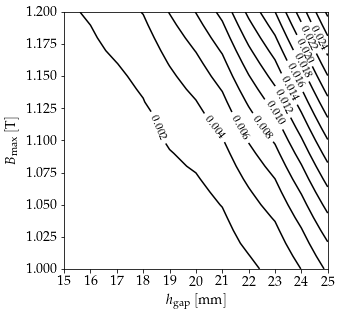

In [86]:
%matplotlib inline
plot_K_maps(100,45)

## Combined maps

### The estimated operating point

To define the target operating point, consider the refrigerated cabinet to be operated by the AMR system. The *cold source* is the refrigerated space inside the cabinet, and the *hot source* is the environment. In steady state, the cooling capacity must be high enough to maintain the interior at the cold temperature $T_{\mathrm{C}}$, despite heat leakage to the environment.

The experimental value of the thermal conductance of the cabinet between the interior and the environment is:

In [15]:
UA_CABINET_EXPERIMENTAL = 1.8 # W/K

and the temperature span is:

In [16]:
TARGET_TEMPERATURE_SPAN_CABINET = 20 # K 

and hence the target cooling capacity is:

In [17]:
TARGET_COOLING_CAPACITY = UA_CABINET_EXPERIMENTAL * TARGET_TEMPERATURE_SPAN_CABINET

For the heat exchangers that have been tested, a system temperature span of 20 K generate a regenerator temperature span of 35 K, so the maps of section 1 can be used.

To account for numerical errors and for the uncertainty in selecting the heat exchanger, we use a safety factor when specifying the actual target cooling capacity:

In [18]:
SAFETY_FACTOR = 3
Q_C_CRITICAL = TARGET_COOLING_CAPACITY * SAFETY_FACTOR

### Combining maps for the external radius and cooling capacity

This map shows how to select the minimum radius required to achieve a given cooling capacity, for various magnetic profiles and regenerator heights. The region above the critical cooling capacity is filled. **The radius values shown already account for the iron shell**

In [19]:
R_C_MIN = 95
R_C_MAX = 135
R_C_STEP = 10

N_QC_LEVELS = 12

B_MIN = 1.00
B_MAX = 1.20

# MAGNET DATA
R_O = 1e3*FIXED_PARAMETERS_MAGNET["R_o"] # [mm]
PHI_S_IV = 45 # [degree]

QC_MAPS_FILE = "AMR_maps_Hreg_W30.txt"

In [20]:
def filter_span_to_20K(table):
    """
    Interpolates the given DataFrame 'table' and return a pandas DataFrame, 
    where all the rows have dT_span = 20 K, """
    
    DT = 20
    
    Teste_vector = table_slope_2D['Teste'].unique()
    table = DataFrame()

    sim_row = {}
    
    i_sim = 1
    for teste in Teste_vector:
        
        table_teste = regsim.filter_table_from_column(table,'Teste',teste)

        f_Qc = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['Qc[W]'], fill_value='extrapolate')
        f_COP = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['COP[-]'], fill_value='extrapolate')

        H = table_teste['H[mm]'].values[0]
        Hmax = table_teste['Hmax[T]'].values[0]

        sim_row["Teste"] = teste
        sim_row["H[mm]"] = H
        sim_row["Hmax[T]"] = Hmax
        sim_row["Qc[W]"] = f_Qc(DT)
        sim_row["COP[-]"] = f_COP(DT)

        sim_row_df = DataFrame(sim_row,index=[i_sim,])
        sim_row_df.index.name = "Case"
        table = pd.concat([table,sim_row_df])
        i_sim = i_sim + 1
                
    return tablev

In [21]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s, map_table) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]. 
    
    The last element is a pandas DataFrame with the corresponding result.
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with file_path.open() as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s,map_table)

In [22]:
(h_gap,B_max,R_s,map_table) = get_Rs_map_vectors(40,45)

In [23]:
R_s

array([[ 90.,  90.,  90.,  95.,  95.,  95., 100., 100., 105., 110., 110.],
       [ 90.,  90.,  90.,  95.,  95.,  95., 100., 105., 105., 110., 110.],
       [ 90.,  90.,  90.,  95.,  95., 100., 100., 105., 105., 110., 115.],
       [ 90.,  90.,  90.,  95.,  95., 100., 100., 105., 105., 110., 115.],
       [ 90.,  90.,  90.,  95., 100., 100., 100., 105., 110., 110., 115.],
       [ 90.,  90.,  95.,  95., 100., 100., 105., 105., 110., 110., 115.],
       [ 90.,  90.,  95.,  95., 100., 100., 105., 105., 110., 115., 115.],
       [ 90.,  95.,  95., 100., 100., 100., 105., 110., 110., 115., 120.],
       [ 90.,  95.,  95., 100., 100., 105., 105., 110., 110., 115., 120.],
       [ 90.,  95.,  95., 100., 100., 105., 105., 110., 115., 115., 120.],
       [ 95.,  95.,  95., 100., 105., 105., 110., 110., 115., 115., 120.],
       [ 95.,  95., 100., 100., 105., 105., 110., 110., 115., 120., 120.],
       [ 95.,  95., 100., 100., 105., 105., 110., 115., 115., 120., 125.],
       [ 95., 100., 100.,

In [27]:
def plot_Qc_and_Rs_contour():    
    
    table_Qc = pd.read_csv(QC_MAPS_FILE,sep='\t')

    HMax_vector = table_Qc['Hmax[T]'].unique()
    H_reg_vector = table_Qc['H[mm]'].unique()

    Qc_matrix = np.zeros((len(HMax_vector),len(H_reg_vector)))
    COP_matrix = Qc_matrix.copy()
    
    fig_list = []
    table_list = []
    
    fig_Qc, ax_Qc = nemplot.create_plot(title='',
                                        xlabel=H_REG_LABEL,
                                        ylabel=B_LABEL) 

    Qc_vector = table_Qc['Qc[W]'].values
    COP_vector = table_Qc['COP[-]'].values
    
    #transformando o vetor Qc em matriz
    cont = 0
    for i in range(len(H_reg_vector)):
        for j in range(len(HMax_vector)):                            
            Qc_matrix[j,i] = Qc_vector[cont]
            COP_matrix[j,i] = COP_vector[cont]
            cont += 1
    
    H_reg_grid,B_max_grid = np.meshgrid(H_reg_vector,HMax_vector)
    
    Q_c_min = np.min(Qc_matrix)
    Q_c_max = np.max(Qc_matrix)
    
    # build the Q_c_levels by partinioning the range below and above the critical value,
    # making sure it is included in the list
    Q_c_levels = np.append(np.linspace(Q_c_min,Q_C_CRITICAL,int(N_QC_LEVELS/2),endpoint=False),
                           np.linspace(Q_C_CRITICAL,Q_c_max,int(N_QC_LEVELS/2)))
    
    p_Qc = ax_Qc.contour(H_reg_grid,B_max_grid,Qc_matrix,Q_c_levels,colors='gray',linestyles='dashed')
    ax_Qc.clabel(p_Qc,fmt="%d",fontsize=0.9*nemplot_parameters["FONTSIZE"])
    
    # fill the contour between the critical and the maximum value of cooling capacity
    p_Qc_fill = ax_Qc.contourf(H_reg_grid,
                               B_max_grid,
                               Qc_matrix,
                               levels=[Q_C_CRITICAL,Q_c_max,],
                              colors='#cccccc')
    
    # load the magnet data
    h_gap_magnet,B_max_magnet,R_s_magnet,_ = get_Rs_map_vectors(R_O,PHI_S_IV)
    H_reg_magnet = h_gap_magnet - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    R_c_magnet = R_s_magnet + 1e3*FIXED_PARAMETERS_MAGNET["h_fc"]
    
    p_Rs = ax_Qc.contour(H_reg_magnet,
                         B_max_magnet,
                         R_c_magnet,
                         levels=np.arange(R_C_MIN,R_C_MAX + R_C_STEP,R_C_STEP),
                         colors='k',
                        linestyles='solid')
    ax_Qc.clabel(p_Rs,
                 fmt="%d",
                 fontsize=0.9*nemplot_parameters["FONTSIZE"],
                rightside_up=False)
    
    
    H_reg_min = np.min(H_reg_magnet)
    H_reg_max = np.max(H_reg_magnet)
    dH_reg = 2
    
    H_reg_ticks = np.arange(H_reg_min, H_reg_max + dH_reg, dH_reg)
    h_gap_ticks = H_reg_ticks + 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    h_gap_ticklabels = ["%d" %(h_gap,) for h_gap in h_gap_ticks]
    
    ax_Qc.set_xlim(np.min(H_reg_magnet),np.max(H_reg_magnet))
    ax_Qc.set_xticks(H_reg_ticks)
    nemplot.refine_xticks(ax_Qc,5)
    
    # add axis at the top for the air gap height
    ax_hgap = ax_Qc.twiny()
    ax_hgap.set_xlim(ax_Qc.get_xlim())
    ax_hgap.set_xticks(H_reg_ticks)
    ax_hgap.set_xticklabels(h_gap_ticklabels,
                           fontdict={"fontsize": nemplot_parameters["FONTSIZE"]})
    ax_hgap.set_xlabel(H_GAP_LABEL,fontsize=nemplot.nemplot_parameters["FONTSIZE"])
    
    B_max_min = B_MIN
    B_max_max = B_MAX
    dB_max = 0.05
    
    ax_Qc.set_ylim(B_MIN,B_MAX)
    B_max_ticks = np.arange(B_max_min,B_max_max + dB_max, dB_max)
    ax_Qc.set_yticks(B_max_ticks)
    nemplot.refine_yticks(ax_Qc,5)
    
    ax_Qc.grid(True)
    
    fig_list.append(fig_Qc)

    
    nemplot.save_figure(fig_Qc,
                        name='contour_Qc_Rs_W30')

    return fig_list, table_list

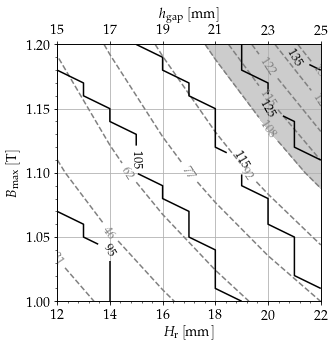

In [28]:
%matplotlib inline
fig_list_slope2D_35K = plot_Qc_and_Rs_contour()

It seems that an external radius of 120 mm can easily satisfy the target cooling capacity. We can select three operating points for three values of the magnetic field:

In [75]:
R_s_target_mm = 120
t_120 = filter_table_from_column(map_table,"R_s[mm]",R_s_target_mm)

In [76]:
B_h_values = np.array([1.1,1.15,1.20])

In [77]:
for B_h in B_h_values:
    
    t = filter_table_from_column(t_120,"B_max[T]",B_h)
    h_gap_max = np.max(t["h_gap[mm]"].values)
    H_reg_max = h_gap_max - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    print("For R_s = %d mm, B_max = %.2f T, the maximum regenerator height is %d mm" %(R_s_target_mm,B_h,H_reg_max))
    

For R_s = 120 mm, B_max = 1.10 T, the maximum regenerator height is 22 mm
For R_s = 120 mm, B_max = 1.15 T, the maximum regenerator height is 20 mm
For R_s = 120 mm, B_max = 1.20 T, the maximum regenerator height is 19 mm


For simulations of these points, comparing situations with and without the internal magnet (using an iron core instead), see the notebook `Comparison with and without the internal magnet.ipynb`.

To find the operating point for the point of $B_{\mathrm{max}} = 1.20\,\mathrm{T}$, we load the AMR simulation results and interpolate the values:

In [78]:
qc_map = pd.read_csv(QC_MAPS_FILE,sep='\t')
B_max_op_point = 1.20
qc_map_B = filter_table_from_column(qc_map,"Hmax[T]",B_max_op_point)
qc_map_B

,H[mm],Hmax[T],Test,Re_w[-],ReDp_CB[-],ReDp_HB[-],U_CB[-],U_HB[-],dPCB[kPa],dPHB[kPa],Tspan [K],dT_reg[K],Qc[W],Qh[W],Wpump[W],Wasco[W],Wmotor[W],COP[-],Q_wall-Loss[W]
2,10,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.669664,49.077647,46.291060,6.016106,20.16,6.350158,1.508862,-591.675271
5,12,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.739557,63.806365,62.602843,7.219327,20.16,8.255907,1.790541,-633.778998
8,14,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.795899,79.134803,79.595724,8.422548,20.16,10.239254,2.038411,-675.789513
11,16,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.842590,94.937258,97.125818,9.625770,20.16,12.283934,2.256666,-717.801504
14,18,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.882094,111.121220,115.092414,10.828991,20.16,14.377977,2.449386,-759.854209
17,20,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.916054,127.619766,133.416110,12.032212,20.16,16.512724,2.620264,-801.930894
20,22,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.945613,144.375459,152.038865,13.235433,20.16,18.680743,2.772390,-844.021700


In [81]:
H_reg_op_point = 19

fQc = interp1d(qc_map_B["H[mm]"].values,qc_map_B["Qc[W]"])
Qc_op_point = fQc(H_reg_op_point)

fCOP = interp1d(qc_map_B["H[mm]"].values,qc_map_B["COP[-]"])
COP_op_point = fCOP(H_reg_op_point)

T_H = FIXED_PARAMETERS_AMR["T_H[K]"]
T_C = T_H - FIXED_PARAMETERS_AMR["dT[K]"]

COP_Carnot_op_point = T_C / (T_H - T_C)

eta_2nd = COP_op_point / COP_Carnot_op_point

print("Operating point for the magnet:")
print("B_max = %.2f T" %(B_max_op_point))
print("H_reg = %d mm" %(H_reg_op_point))
print("***")
print("Performance:")
print("Q_c = %.1f W" %(Qc_op_point))
print("COP = %.1f" %(COP_op_point))
print("Second-law efficienct: %.1f %%" % (1e2*eta_2nd))



Operating point for the magnet:
B_max = 1.20 T
H_reg = 19 mm
***
Performance:
Q_c = 119.4 W
COP = 2.5
Second-law efficienct: 32.8 %
